# 1. Установка библиотек

In [1]:
#! pip install --user pandas numpy matplotlib seaborn scikit-learn xgboost catboost lightgbm 

# 2. Загрузка библиотек

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score
from sklearn import model_selection, linear_model, metrics
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression,Lasso, Ridge, SGDRegressor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM, SVR
from sklearn.neighbors import KNeighborsRegressor

from evaluating import evaluating

base_context = 'fivethirtyeight'

import shap


# 3. Загрузка и подготовка данных 

## 3.1 Загрузка данных по всем экспериментам

In [3]:
# чтение имен всех файлов с данными

all_files = []
for root, dirs, files in os.walk("/kaggle/input/ml-cource-cifrum-anomaly-public/data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(f'{root}/{file}')

print("Список файлов:")
all_files.sort()
display(all_files)

Список файлов:


['/kaggle/input/ml-cource-cifrum-anomaly-public/data/anomaly-free/anomaly-free.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/1.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/10.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/11.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/12.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/13.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/14.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/2.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/3.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/4.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/5.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/6.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/7.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/8.csv',
 '/kaggle/input/ml-cource-cifrum-anomal

In [4]:
# загрузка датасетов с аномалиями
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]


Пример визуализации сигналов

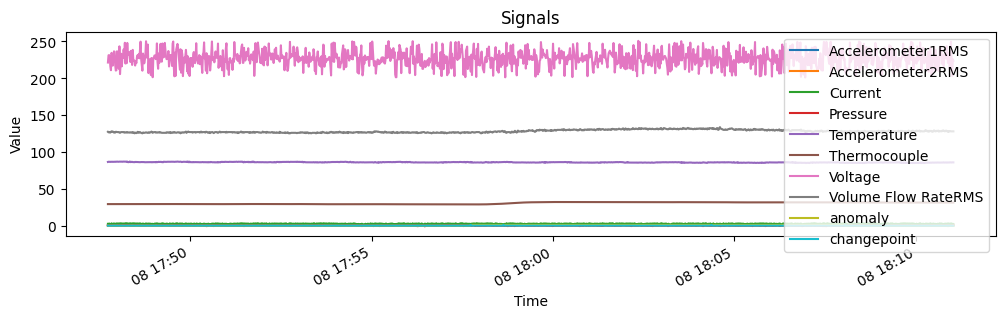

In [5]:
# визуализация всех сигналов по рандомному эксперименту
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

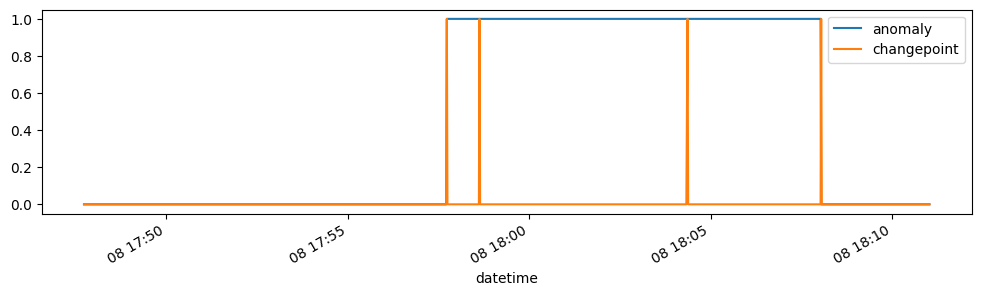

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

Масштабирование (нормализация) будет выполнено в разрезе каждой модели во время их рассмотрения

На основании разведочного анализа были сделаны выводы о том, что в данных отсутствуют пропущенные значения, но необходима фильтрация от нереальных значений и выбросов

## 3.2 Фильтрация данных

In [7]:
list_of_df[0].columns

Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object')

In [8]:
for n in range(len(list_of_df)):
    df = list_of_df[n]
    for col in df.columns:
        df[df < 0] = 0
    list_of_df[n] = df    

In [9]:
list_of_df[0]

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0
2020-03-01 15:44:07,0.082724,0.132378,1.12118,0.000000,92.0144,22.2577,221.250,76.9806,0.0,0.0
2020-03-01 15:44:08,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0.0,0.0
2020-03-01 15:44:09,0.083335,0.132742,1.25962,0.000000,92.2438,22.2657,230.375,77.0000,0.0,0.0
2020-03-01 15:44:10,0.082272,0.133171,1.59773,0.054711,92.3611,22.2591,249.701,77.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-01 15:57:02,0.080787,0.131610,1.52788,0.000000,90.5728,22.2021,237.739,74.9799,1.0,0.0
2020-03-01 15:57:03,0.081003,0.128565,1.78583,0.000000,90.4393,22.2120,224.866,74.0000,1.0,0.0
2020-03-01 15:57:04,0.079904,0.133247,1.51095,0.000000,90.6200,22.2098,233.475,74.0000,1.0,0.0


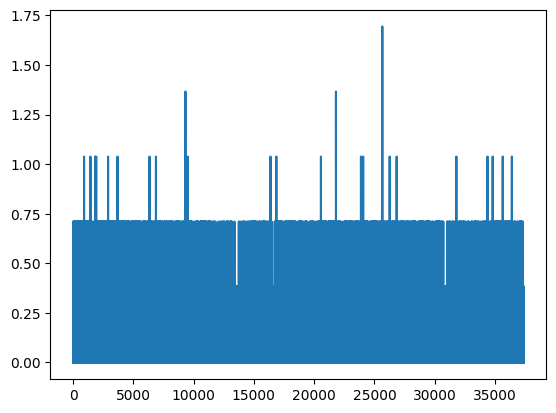

In [10]:
plt.plot(pd.concat(list_of_df).sort_index().reset_index()["Pressure"])

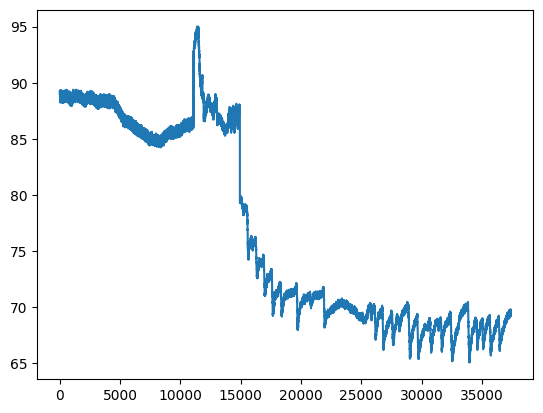

In [11]:
plt.plot(pd.concat(list_of_df).sort_index().reset_index()["Temperature"])

В сигналах давления были отрицательные значения

С помощью фильтрации мы их заполнили нулями

## 3.3 Генерация дополнительных признаков

In [12]:
for ind in range(len(list_of_df)):
    # разница температур (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Temperature_diff"] = list_of_df[ind]['Temperature'] - list_of_df[ind]['Thermocouple'] 
    # разница акселлерометров (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Accel_diff"] = list_of_df[ind]['Accelerometer1RMS'] / list_of_df[ind]['Accelerometer2RMS'] 
    # сглаживания
    list_of_df[ind]["Volume Flow RateRMS_10mean"] = list_of_df[ind]["Volume Flow RateRMS"].rolling(window = 10, min_periods=0).mean()

Проверка созданных признаков

In [13]:
list_of_df[0]

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint,Temperature_diff,Accel_diff,Volume Flow RateRMS_10mean
datetime,,,,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0,69.9985,0.614620,76.01970
2020-03-01 15:44:07,0.082724,0.132378,1.12118,0.000000,92.0144,22.2577,221.250,76.9806,0.0,0.0,69.7567,0.624906,76.50015
2020-03-01 15:44:08,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0.0,0.0,69.9665,0.587234,76.34000
2020-03-01 15:44:09,0.083335,0.132742,1.25962,0.000000,92.2438,22.2657,230.375,77.0000,0.0,0.0,69.9781,0.627794,76.50500
2020-03-01 15:44:10,0.082272,0.133171,1.59773,0.054711,92.3611,22.2591,249.701,77.0000,0.0,0.0,70.1020,0.617794,76.60400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-01 15:57:02,0.080787,0.131610,1.52788,0.000000,90.5728,22.2021,237.739,74.9799,1.0,0.0,68.3707,0.613835,74.10003
2020-03-01 15:57:03,0.081003,0.128565,1.78583,0.000000,90.4393,22.2120,224.866,74.0000,1.0,0.0,68.2273,0.630056,74.10003
2020-03-01 15:57:04,0.079904,0.133247,1.51095,0.000000,90.6200,22.2098,233.475,74.0000,1.0,0.0,68.4102,0.599666,74.10003


# 4. Обучение моделей

## 4.1 Модели обучения без учителя

### 4.1.1 Изолирующий лес


    n_estimators – число деревьев
    max_samples – объём выборки для построения одного дерева (если вещественное число, то процент всей выборки)
    contamination – доля выбросов в выборке (для выбора порога)
    max_features – число (или %) признаков, которые используются при построении одного дерева
    bootstrap – включение режима бутстрепа при формировании подвыборки


#### Обучение и предсказание результата

In [14]:
%%time
# создание списков для хранения предсказаний
predicted_outlier, predicted_cp = [], []
# цикл по всем экспериментам
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # масштабирование данных
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    X_train_trans = StSc.transform(X_train)
    
    X_train = pd.DataFrame(X_train_trans, columns = X_train.columns, index = X_train.index)
                 
    df_trans = StSc.transform(df.drop(['anomaly','changepoint'], axis=1))
    df = pd.DataFrame(df_trans, columns = df.drop(['anomaly','changepoint'], axis = 1).columns, index = df.index)
    
    
    # инициализация модели для поиска аномалий
    model = IsolationForest(random_state=0, n_jobs = -1, n_estimators=100)
    # обучение модели поиска аномалий на обучающей выборке
    model.fit(X_train)

    # предсказание на всей выборке (эксперименте)
    prediction = pd.Series(model.predict(df)*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
    
    # сохранение предсказаний
    predicted_outlier.append(prediction)
    
    
    # инициализация модели для поиска точек изменения состояния
    model = IsolationForest(random_state=0, n_jobs = -1, contamination=0.002, n_estimators = 100)
    # обучение модели поиска точек изменения состояния на обучающей выборке
    model.fit(X_train)
    
    # предсказание на всей выборке (эксперименте)
    prediction = pd.Series(model.predict(df)*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
    
    # сохранение предсказаний точек изменения состояния
    prediction_cp = prediction.rolling(30).max().fillna(0).diff().abs()
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 32.5 s, sys: 3.51 s, total: 36 s
Wall time: 33.9 s


#### Визуализация результатов моделирования

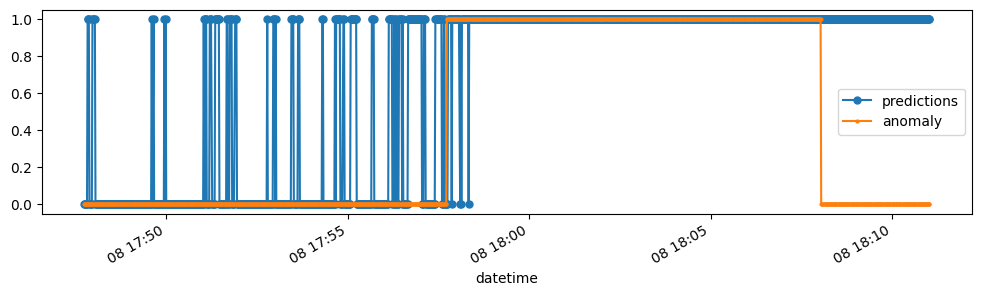

In [15]:
# создание списка с векторами правильных ответов для каждого эксперимента по задаче поиска аномалий
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

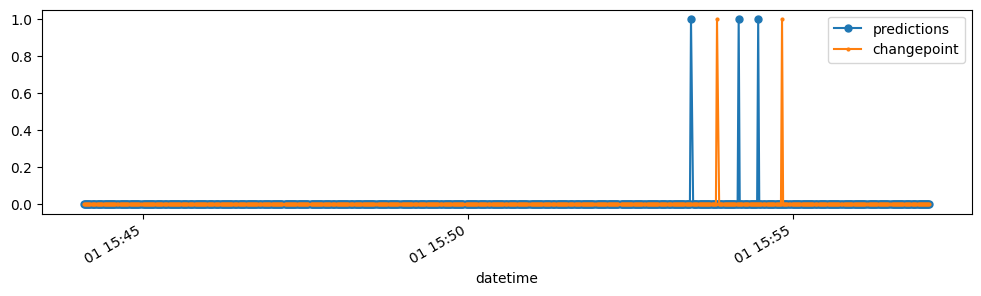

In [16]:
# создание списка с векторами правильных ответов для каждого эксперимента по задаче поиска точек измненения состояния
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

Важность признаков с помощью библиотеки shap

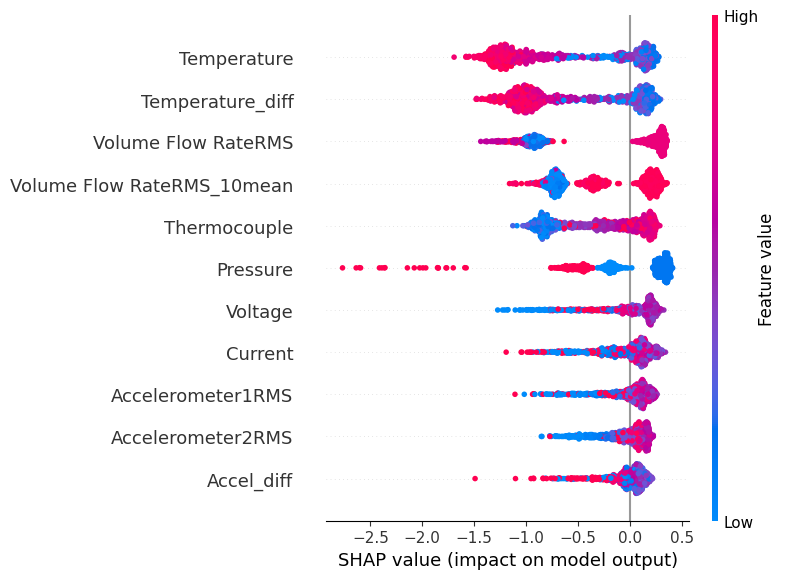

In [17]:
shap_test = shap.TreeExplainer(model).shap_values(df)
shap.summary_plot(shap_test, df,
                      max_display=25, auto_size_plot=True)

Как читать график:

    - значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    - чем толще линия на графике, тем больше таких точек наблюдения
    - чем краснее точки на графике, тем выше значения фичи в ней


#### Оценка точности для задачи поиска аномалий

In [18]:
len(true_outlier)

34

In [19]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [20]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.7036750557779773
Precision:  0.5694768989362415
Recall:  0.933366130108852


Матрица ошибок  для одного временного ряда

<Axes: >

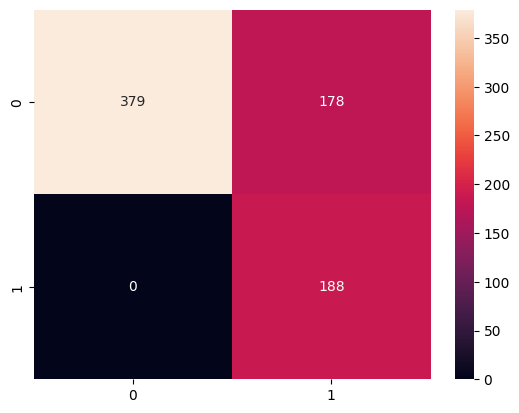

In [21]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

Отчет о классификации для одного временного ряда

In [22]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81       557
         1.0       0.51      1.00      0.68       188

    accuracy                           0.76       745
   macro avg       0.76      0.84      0.74       745
weighted avg       0.88      0.76      0.78       745



#### Оценка точности для задачи поиска точек изменения состояния

In [23]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [24]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.0034602076124567475
Precision:  0.0022624434389140274
Recall:  0.007352941176470588


Метрики классификации не подходят для данной задачи, необходимо использовать среднее время или nab

Смотрим на метрику Standart

In [25]:
# расчет количества положительных и ложных срабатываний, а также среднего времени обнаружения 
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:02:23.600000'), Timestamp('2020-02-08 17:58:38'))
Intersection of scoring windows(Timestamp('2020-02-08 18:09:01.600000'), Timestamp('2020-02-08 18:08:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:24:52.800000'), Timestamp('2020-02-08 18:20:46'))
Intersection of scoring windows(Timestamp('2020-02-08 18:31:06.800000'), Timestamp('2020-02-08 18:28:37'))
Intersection of scoring windows(Timestamp('2020-02-08 18:48:51.600000'), Timestamp('2020-02-08 18:46:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:55:37.600000'), Timestamp('2020-02-08 18:51:55'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:15.800000'), Timestamp('2020-02-08 18:58:30'))
Intersection of scoring windows(Timestamp('2020-02-08 19:06:15.800000'), Timestamp('2020-02-08 19:03:36'))
Intersection of scoring windows(Timestamp('2

In [26]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
    anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


### 4.1.2 One-class SVM

OneClassSVM позволяет задать параметр nu — долю аномальных объектов в выборке.

Рассчитаем долю аномальных объектов в выборке для каждой из задач

In [27]:
print("Доля аномальных объектов для задачи поиска аномалий:", list_of_df[0]["anomaly"].value_counts()[1] / list_of_df[0].shape[0])

Доля аномальных объектов для задачи поиска аномалий: 0.2523489932885906


In [28]:
print("Доля аномальных объектов для задачи поиска точек изменения состояния:", list_of_df[0]["changepoint"].value_counts()[1] / list_of_df[0].shape[0])

Доля аномальных объектов для задачи поиска точек изменения состояния: 0.0026845637583892616


#### Обучение и предсказание результата

In [29]:
%%time
# создание списков для хранения предсказаний
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # масштабирование данных
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    X_train_trans = StSc.transform(X_train)
    
    X_train = pd.DataFrame(X_train_trans, columns = X_train.columns, index = X_train.index)
                 
    df_trans = StSc.transform(df.drop(['anomaly','changepoint'], axis=1))
    df = pd.DataFrame(df_trans, columns = df.drop(['anomaly','changepoint'], axis=1).columns, index = df.index)
    
    
    # инициализация модели
    model = OneClassSVM(kernel='rbf', gamma= "scale", nu=0.25)
    
    # обучение модели поиска аномалий на обучающей выборке
    model.fit(X_train)

    # предсказание на всей выборке (эксперименте)
    prediction = pd.Series(model.predict(df)*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
    
    # сохранение предсказаний
    predicted_outlier.append(prediction)
    
    # сохранение предсказаний
    prediction_cp = prediction.rolling(30).max().fillna(0).diff().abs()
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 855 ms, sys: 0 ns, total: 855 ms
Wall time: 857 ms


#### Визуализация результатов моделирования

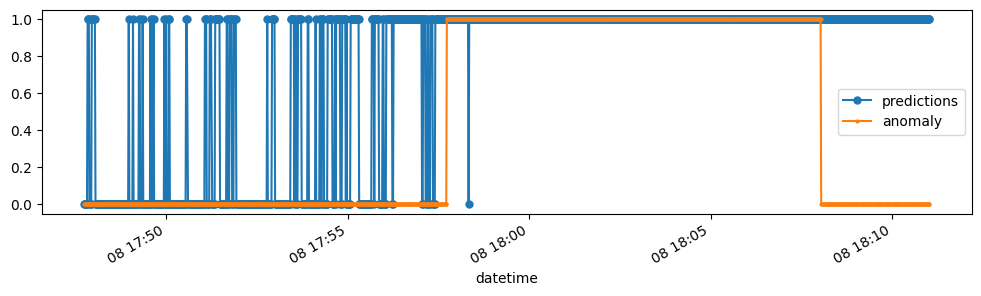

In [30]:
# создание списка с векторами правильных ответов для каждого эксперимента по задаче поиска аномалий
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

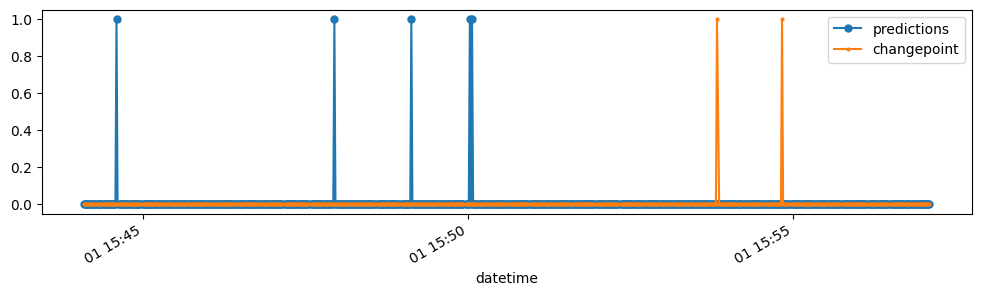

In [31]:
# создание списка с векторами правильных ответов для каждого эксперимента по задаче поиска точек изменения состояния
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

Важность признаков

In [32]:
df[:10]

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,Temperature_diff,Accel_diff,Volume Flow RateRMS_10mean
datetime,,,,,,,,,,,
2020-03-09 16:56:31,-0.129948,-0.163475,-0.091778,-0.418336,2.814591,0.129192,0.578788,-0.151217,2.830575,0.080596,-0.583179
2020-03-09 16:56:32,-0.426205,0.248278,1.005551,-0.418336,2.534160,0.187379,-0.212861,-0.151217,2.546702,-0.419288,-0.583179
2020-03-09 16:56:33,-0.726586,0.259627,1.360670,-0.418336,2.572264,-0.439750,0.895669,-0.151217,2.601390,-0.536495,-0.583179
2020-03-09 16:56:34,-0.628226,-1.017548,1.083100,-0.759552,2.511598,-0.342771,1.709321,-0.047977,2.537784,0.750662,-0.483542
2020-03-09 16:56:35,-0.694781,-2.148392,1.451478,-0.418336,2.455111,-0.472076,0.786574,2.143774,2.484274,1.929284,1.268453
2020-03-09 16:56:36,-0.604667,-1.741633,1.895441,1.626848,2.604852,-0.038905,1.866749,-0.251343,2.623770,1.519643,0.895426
2020-03-09 16:56:37,-1.356207,-0.690461,1.265678,-0.418336,2.315063,0.542967,-0.088484,-2.443334,2.316844,0.153120,-0.579877
2020-03-09 16:56:38,-1.216913,0.592389,1.837557,1.626848,2.092456,0.433058,-0.311092,-0.151217,2.095568,-1.017275,-0.580290
2020-03-09 16:56:39,-1.087337,0.053827,1.361004,-0.418336,2.617888,0.180914,-0.116747,-0.151217,2.631174,-0.470904,-0.580611


In [33]:
#e = shap.KernelExplainer(model.decision_function, X_train) 
#shap_values = e.shap_values(df)
#features = df.columns

#shap.initjs()
#shap.force_plot(e.expected_value[0], shap_values[0][0], features = features)
#shap.summary_plot(shap_values[0], X_test, feature_names=features)


####  Оценка точности для задачи поиска аномалий

In [34]:
len(true_outlier)

34

In [35]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [36]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.675146739271812
Precision:  0.5249115469213927
Recall:  0.9542187465284063


Для одного временного ряда

Матрица ошибок

<Axes: >

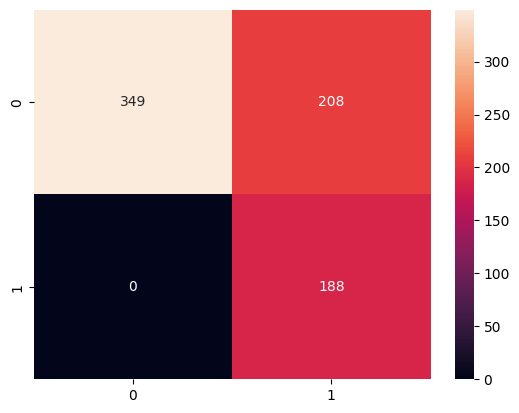

In [37]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

In [38]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       1.00      0.63      0.77       557
         1.0       0.47      1.00      0.64       188

    accuracy                           0.72       745
   macro avg       0.74      0.81      0.71       745
weighted avg       0.87      0.72      0.74       745



####  Оценка точности для задачи поиска точек изменения состояния

In [42]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [43]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.0
Precision:  0.0
Recall:  0.0


In [44]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


## 4.2 Модели обучения с учителем

### 4.2.1 Одномерное прогнозирование (предсказываем аномалию по одному признаку)

#### 4.2.1.1 Линейная регрессия

In [45]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Пример работы функции (вывод размерностей массивов)

In [46]:
look_back = 5
train = list_of_df[0][:400].drop(['anomaly','changepoint'], axis=1)

# convert into input/output
X, y = create_dataset(train['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    

In [47]:
X.shape

(395, 5)

In [48]:
X

array([[76.0197, 76.9806, 76.0197, 77.    , 77.    ],
       [76.9806, 76.0197, 77.    , 77.    , 77.    ],
       [76.0197, 77.    , 77.    , 77.    , 77.    ],
       ...,
       [76.9804, 76.0199, 76.9804, 76.0199, 77.    ],
       [76.0199, 76.9804, 76.0199, 77.    , 76.9804],
       [76.9804, 76.0199, 77.    , 76.9804, 76.0199]])

In [49]:
y.shape

(395,)

In [50]:
# создание списка с векторами правильных ответов для каждого эксперимента по задаче поиска аномалий
true_outlier = [df.anomaly for df in list_of_df]

In [51]:
true_outlier[0].shape

(745,)

In [52]:
X[:10]

array([[76.0197, 76.9806, 76.0197, 77.    , 77.    ],
       [76.9806, 76.0197, 77.    , 77.    , 77.    ],
       [76.0197, 77.    , 77.    , 77.    , 77.    ],
       [77.    , 77.    , 77.    , 77.    , 76.9806],
       [77.    , 77.    , 77.    , 76.9806, 76.0197],
       [77.    , 77.    , 76.9806, 76.0197, 77.    ],
       [77.    , 76.9806, 76.0197, 77.    , 77.    ],
       [76.9806, 76.0197, 77.    , 77.    , 76.9806],
       [76.0197, 77.    , 77.    , 76.9806, 76.0197],
       [77.    , 77.    , 76.9806, 76.0197, 77.    ]])

Каждый раз X сдвигается на 1 шаг и берется окно размером 5

In [53]:
y.shape

(395,)

In [54]:
y[:10]

array([77.    , 77.    , 76.9806, 76.0197, 77.    , 77.    , 76.9806,
       76.0197, 77.    , 77.    ])

"y" представляет собой вектор значений признака на 1 точку в будущем

In [55]:
# параметры для обучения
look_back = 5
Q = 0.98

In [56]:
%%time

# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    test = df.drop(['anomaly','changepoint'], axis=1)
    y = df["anomaly"]
    
    # масштабирование данных
    StSc = StandardScaler()
    StSc.fit(train['Volume Flow RateRMS'].values.reshape(-1,1))
    
    
    
    # Берем признак - Расход
    X_train, y_train = create_dataset(StSc.transform(train['Volume Flow RateRMS'].values.reshape(-1,1)), look_back)
    
    X_test, y_test = create_dataset(StSc.transform(test['Volume Flow RateRMS'].values.reshape(-1,1)), look_back)
    
    # инициализация модели
    model = LinearRegression()
    # обучение модели
    model.fit(X_train, y_train)
    
    # построение прогноза, расчет невязки и подбор порога на обучающей выборке
    residuals_train = pd.DataFrame(y_train - model.predict(X_train)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) 
    
    #предсказание на тестовой выборке
    residuals = pd.DataFrame(y_test - model.predict(X_test)).abs().sum(axis=1)
    
    anomalous_data = residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(look_back - 1, len(X_test) - look_back + 1):
        if np.all(anomalous_data[data_idx - look_back + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=test.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # поиск точек изменения состояния в прогнозе аномалий и сохранение в массив
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 2.18 s, sys: 0 ns, total: 2.18 s
Wall time: 2.2 s


In [57]:
UCL

2.4425821496118814

##### Визуализация результатов моделирования

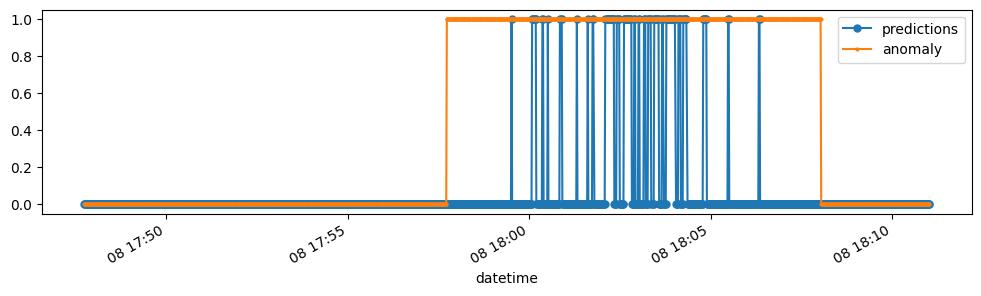

In [58]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

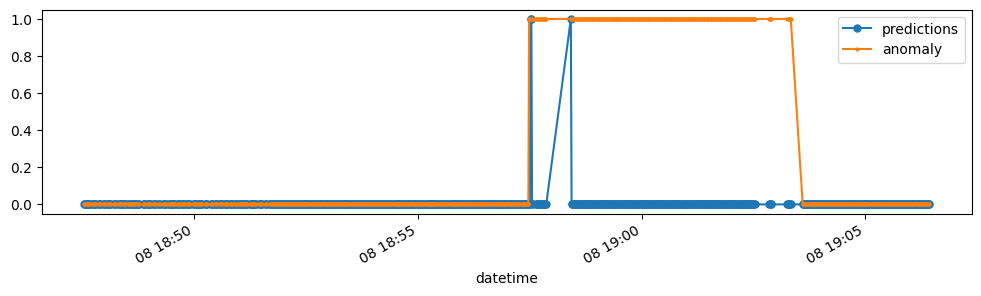

In [59]:
predicted_outlier[4].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[4].plot(marker='o', markersize=2)
plt.legend();

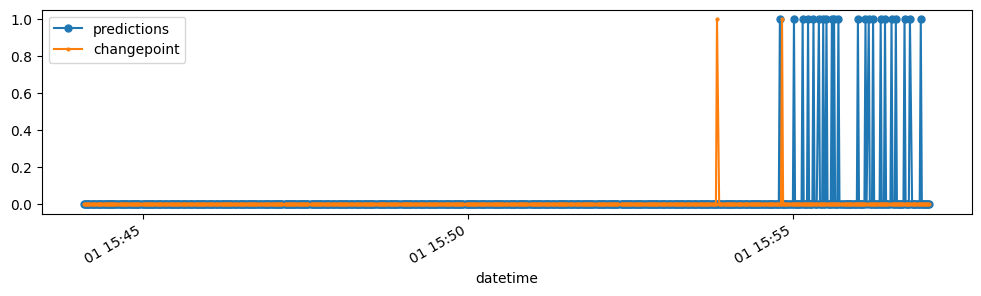

In [60]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

График невязки

Text(0.5, 1.0, 'Невязка модели')

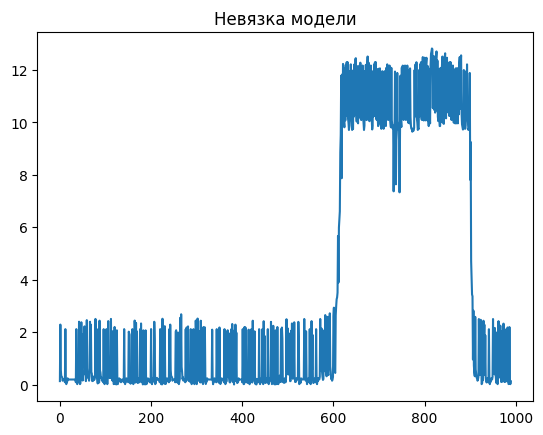

In [61]:
plt.plot(residuals)
plt.title("Невязка модели")

##### Оценка точности для задачи поиска аномалий

In [63]:
len(true_outlier)

34

In [64]:
predicted_outlier[0]

datetime
2020-03-01 15:44:06    0
2020-03-01 15:44:07    0
2020-03-01 15:44:08    0
2020-03-01 15:44:09    0
2020-03-01 15:44:10    0
                      ..
2020-03-01 15:57:02    0
2020-03-01 15:57:03    0
2020-03-01 15:57:04    0
2020-03-01 15:57:05    0
2020-03-01 15:57:06    0
Length: 745, dtype: int64

In [65]:
true_outlier[0]

datetime
2020-03-01 15:44:06    0.0
2020-03-01 15:44:07    0.0
2020-03-01 15:44:08    0.0
2020-03-01 15:44:09    0.0
2020-03-01 15:44:10    0.0
                      ... 
2020-03-01 15:57:02    1.0
2020-03-01 15:57:03    1.0
2020-03-01 15:57:04    1.0
2020-03-01 15:57:05    1.0
2020-03-01 15:57:06    1.0
Name: anomaly, Length: 745, dtype: float64

In [66]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [67]:
f1

[0.5648854961832062,
 0.30390738060781475,
 0.06818181818181818,
 0.8,
 0.022388059701492536,
 0.0,
 0.0,
 0.36475409836065575,
 0.005025125628140704,
 0.0,
 0.0,
 0.0,
 0.0,
 0.7982326951399116,
 0.014851485148514849,
 0.0,
 0.8688293370944993,
 0.8468208092485549,
 0.9247311827956989,
 0.9023383768913342,
 0.8472622478386168,
 0.8543956043956045,
 0.0,
 0.6600331674958541,
 0.0,
 0.8711484593837534,
 0.4745762711864407,
 0.851063829787234,
 0.9949748743718593,
 0.8817802503477051,
 0.030000000000000002,
 0.8517241379310345,
 0.8633093525179857,
 0.86002886002886]

In [68]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.45662479177254683
Precision:  0.690717551819121
Recall:  0.38997053227923184


Для одного временного ряда

Матрица ошибок

<Axes: >

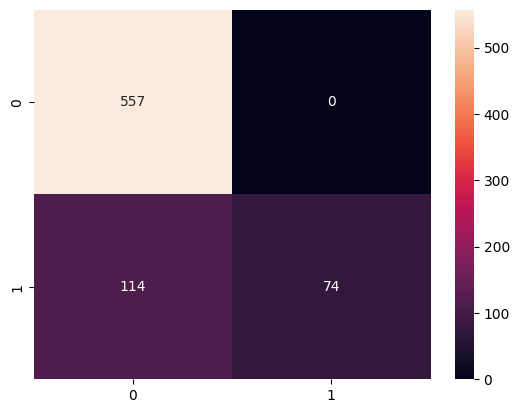

In [69]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

In [70]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       557
         1.0       1.00      0.39      0.56       188

    accuracy                           0.85       745
   macro avg       0.92      0.70      0.74       745
weighted avg       0.87      0.85      0.82       745



##### Оценка точности для задачи поиска точек изменения состояния

In [71]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [72]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.008529411764705883
Precision:  0.007992327365728899
Recall:  0.014705882352941176


In [73]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.1.2 Линейная регрессия (с регуляризацией)

Важные параметры:
    
    alpha - параметр регуляризации (если 0 - то модель не штрафуется)
    max_iter - количество итераций

In [74]:
%%time
look_back = 5


# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    test = df.drop(['anomaly','changepoint'], axis=1)
    y = df["anomaly"]
    
    
    # масштабирование данных
    StSc = StandardScaler()
    StSc.fit(train['Volume Flow RateRMS'].values.reshape(-1,1))
    
    
    
    # Берем признак - Расход
    X_train, y_train = create_dataset(StSc.transform(train['Volume Flow RateRMS'].values.reshape(-1,1)), look_back)
    
    X_test, y_test = create_dataset(StSc.transform(test['Volume Flow RateRMS'].values.reshape(-1,1)), look_back)
    
    
    model = Ridge(alpha=0.1, max_iter = 10000, random_state=42)
    # обучение модели
    model.fit(X_train, y_train)
    
    # построение прогноза, расчет невязки и подбор порога на обучающей выборке
    residuals_train = pd.DataFrame(y_train - model.predict(X_train)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) * 1.1
    
     #предсказание на тестовой выборке
    residuals = pd.DataFrame(y_test - model.predict(X_test)).abs().sum(axis=1)
    
    anomalous_data = residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(look_back - 1, len(X_test) - look_back + 1):
        if np.all(anomalous_data[data_idx - look_back + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=test.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    
    # поиск точек изменения состояния в прогнозе аномалий и сохранение в массив
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 2.12 s, sys: 0 ns, total: 2.12 s
Wall time: 2.13 s


##### Визуализация результатов моделирования

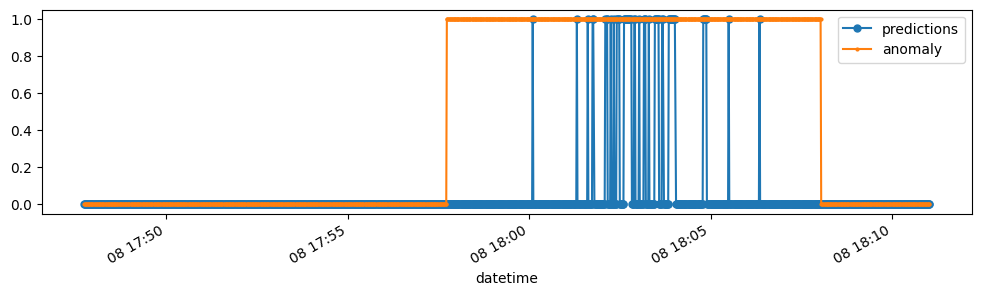

In [75]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

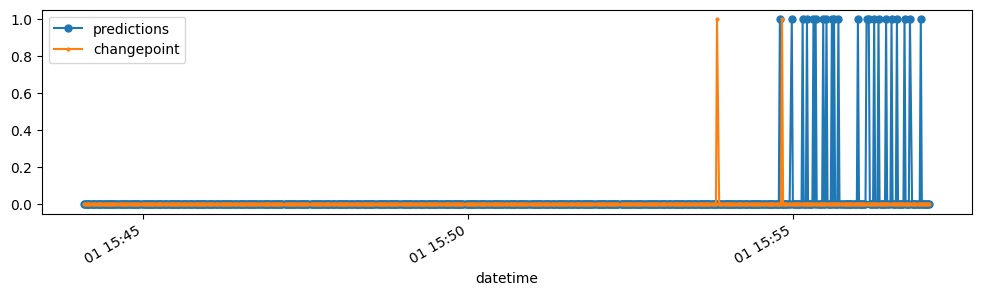

In [76]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

Невязка модели

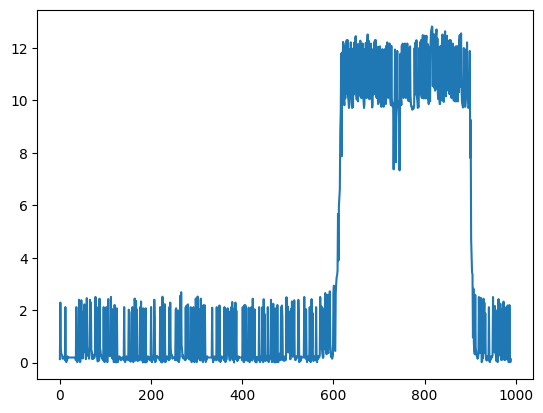

In [77]:
plt.plot(residuals);

##### Оценка точности для задачи поиска аномалий

In [78]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [79]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.4271125272911803
Precision:  0.680951344150112
Recall:  0.36391682680251464


Для одного временного ряда

<Axes: >

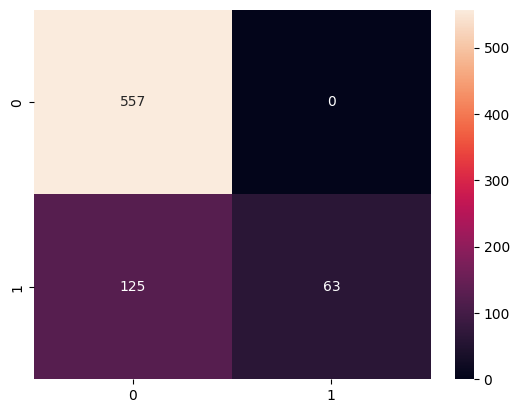

In [80]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

In [81]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       557
         1.0       1.00      0.34      0.50       188

    accuracy                           0.83       745
   macro avg       0.91      0.67      0.70       745
weighted avg       0.86      0.83      0.80       745



##### Оценка точности для задачи поиска точек изменения состояния

In [82]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [83]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.012254901960784312
Precision:  0.011029411764705883
Recall:  0.014705882352941176


In [84]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.1.3 KNN

Гиперпараметры для настройки:

    n_neighbors - количество соседей
    weights - веса точек (uniform - у всех одинаковый вес, distance - веса точек пропорциональны расстоянию)
    

In [85]:
%%time
look_back = 5


# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    test = df.drop(['anomaly','changepoint'], axis=1)
    y = df["anomaly"]
    
    
    # масштабирование данных
    StSc = StandardScaler()
    StSc.fit(train['Volume Flow RateRMS'].values.reshape(-1,1))
    
    
    
    # Берем признак - Расход
    X_train, y_train = create_dataset(StSc.transform(train['Volume Flow RateRMS'].values.reshape(-1,1)), look_back)
    
    X_test, y_test = create_dataset(StSc.transform(test['Volume Flow RateRMS'].values.reshape(-1,1)), look_back)
    
    
    model = KNeighborsRegressor(n_neighbors=7)
    # обучение модели
    model.fit(X_train, y_train)
    
    # построение прогноза, расчет невязки и подбор порога на обучающей выборке
    residuals_train = pd.DataFrame(y_train - model.predict(X_train)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) * 1.1
    
    # предсказание на тестовой выборке
    residuals = pd.DataFrame(y_test - model.predict(X_test)).abs().sum(axis=1)
    
    anomalous_data = residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(look_back - 1, len(X_test) - look_back + 1):
        if np.all(anomalous_data[data_idx - look_back + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=test.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    
    # поиск точек изменения состояния в прогнозе аномалий и сохранение в массив
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 2.35 s, sys: 0 ns, total: 2.35 s
Wall time: 2.36 s


##### Визуализация результатов моделирования

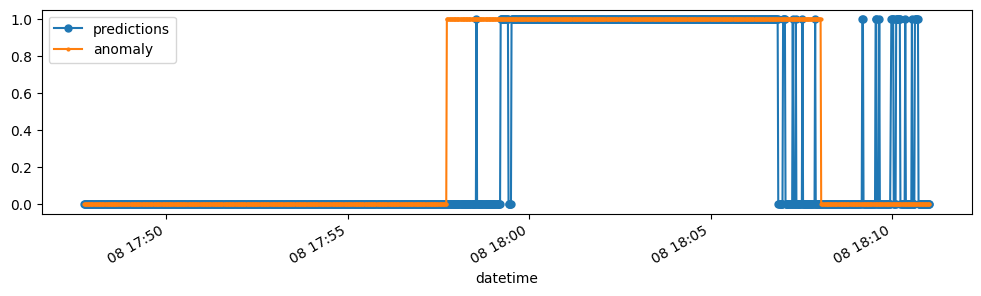

In [86]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

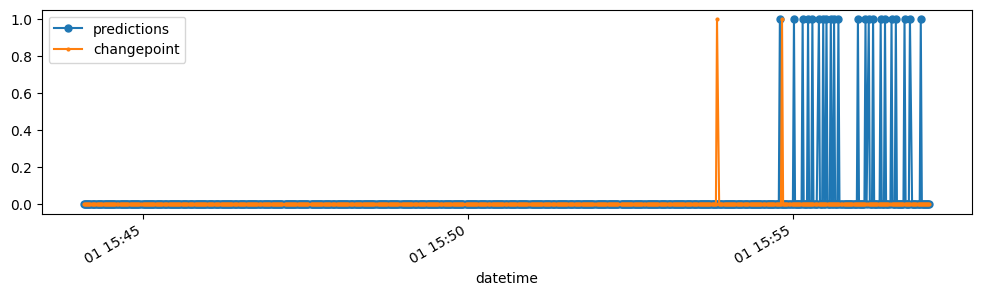

In [87]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

Невязка модели

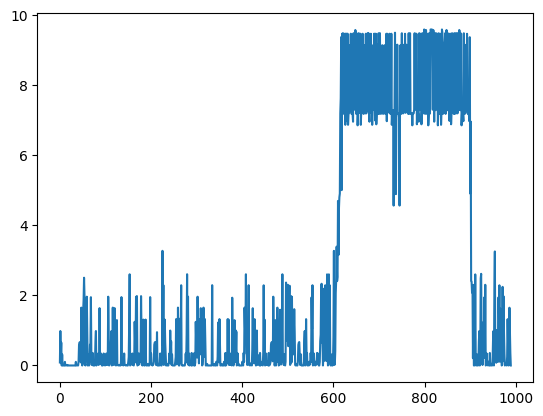

In [88]:
plt.plot(residuals)

##### Оценка точности для задачи поиска аномалий

In [89]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [90]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.5136091297164366
Precision:  0.7770376547832096
Recall:  0.4480068564663883


Для одного временного ряда

<Axes: >

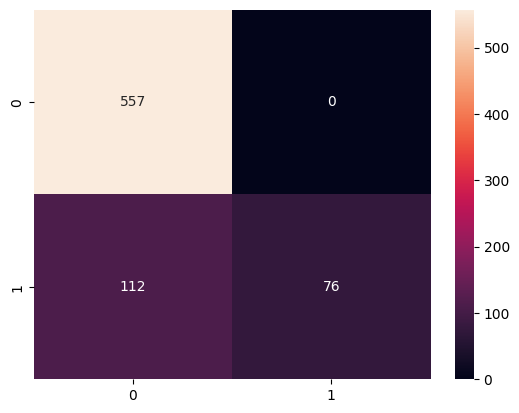

In [91]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

In [92]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       557
         1.0       1.00      0.40      0.58       188

    accuracy                           0.85       745
   macro avg       0.92      0.70      0.74       745
weighted avg       0.87      0.85      0.82       745



##### Оценка точности для задачи поиска точек изменения состояния

In [93]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [94]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.03260263381370648
Precision:  0.028874434389140273
Recall:  0.058823529411764705


In [95]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.1.4 Деревья решений

Гиперпараметры для настройки:

+ max_depth - глубина дерева
    
+ criterion - критерий для разбиения дерева ("squared_error", "friedman_mse", "absolute_error")
        
+ min_samples_split - минимальное количество выборок, необходимых для разделения узла (то есть порог для разделения дерева, если выборок меньше в узле, то разделения не будет).
+ min_samples_leaf - требуемое минимальное количество выборок, которые должны присутствовать в конечном узле. Оно действует как пороговое значение для остановки процесса разделения и обозначения узла как конечного. (дерево разделяется 
+ max_features - количество функций, которые необходимо учитывать при поиске наилучшего разделения в дереве решений. 

Он может либо определять точное количество объектов, которые необходимо учитывать при каждом разделении, либо в процентах, представляющих долю объектов, которые необходимо учитывать. Параметрами ввода могут быть целое число, значение с плавающей точкой, auto, sqrt, log2. Оно функционирует следующим образом:

        автоматически – Это позволяет алгоритму дерева решений учитывать все особенности для каждого разделения.
        sqrt – позволяет алгоритму учитывать только квадратный корень из общего числа функций для каждого разделения
        log2 – Позволяет алгоритму учитывать основание логарифма 2 от общего количества функций для каждого разделения.
        
+ min_weight_fraction_leaf - используется для управления структурой дерева на основе весов, присвоенных каждой выборке. 

Этот гиперпараметр определяет минимальную долю входных выборок, требуемую для конечного узла. Это также может помочь справиться с дисбалансом классов, когда у одного класса может быть особенно меньше выборок, чем у других, для устранения дисбаланса классов мы используем веса выборок. 

https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/

In [96]:
%%time
look_back = 5


# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    test = df.drop(['anomaly','changepoint'], axis=1)
    y = df["anomaly"]
    
    
    # Берем признак - Расход
    X_train, y_train = create_dataset(train['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    
    X_test, y_test = create_dataset(test['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    
    
    # инициализация модели
    model = DecisionTreeRegressor(max_depth = 10, criterion="squared_error", max_features="auto", min_samples_split=10, 
                             min_samples_leaf= 10, min_weight_fraction_leaf=0)
    # обучение модели
    model.fit(X_train, y_train)
    
    # построение прогноза, расчет невязки и подбор порога на обучающей выборке
    residuals_train = pd.DataFrame(y_train - model.predict(X_train)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) * 1.1
    
    #предсказание на тестовой выборке
    residuals = pd.DataFrame(y_test - model.predict(X_test)).abs().sum(axis=1)
    
    anomalous_data = residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(look_back - 1, len(X_test) - look_back + 1):
        if np.all(anomalous_data[data_idx - look_back + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=test.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    
    # поиск точек изменения состояния в прогнозе аномалий и сохранение в массив
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 2.12 s, sys: 294 µs, total: 2.12 s
Wall time: 2.12 s


##### Визуализация результатов моделирования

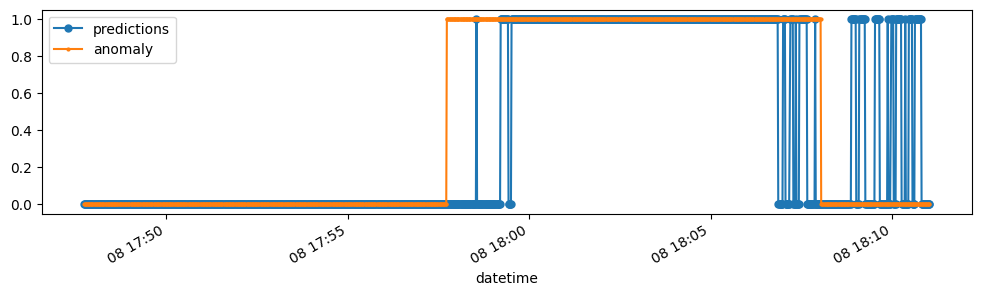

In [97]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

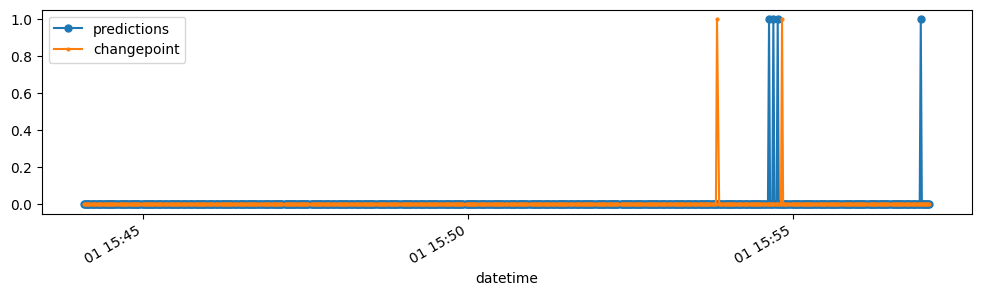

In [98]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

Невязка модели

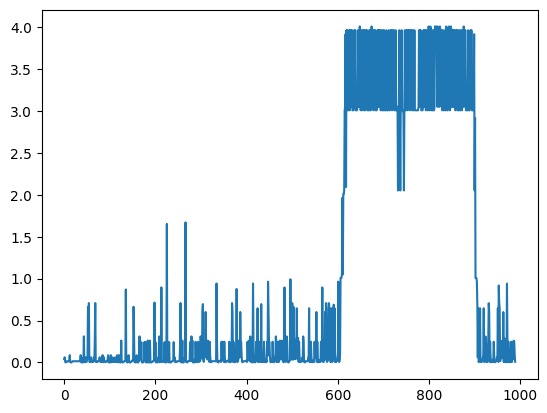

In [99]:
plt.plot(residuals)

##### Оценка точности для задачи поиска аномалий

In [100]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [101]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.5603770375179845
Precision:  0.7008891696142003
Recall:  0.5046421705210586


Для одного временного ряда

<Axes: >

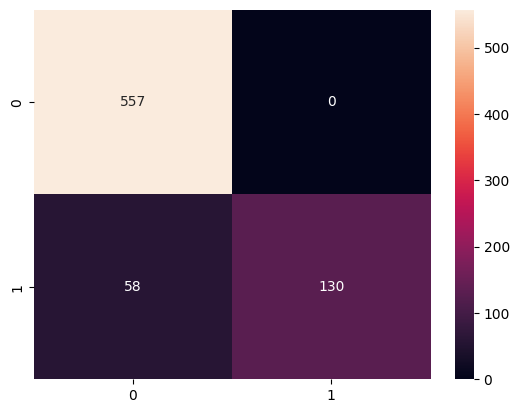

In [102]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

In [103]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       557
         1.0       1.00      0.69      0.82       188

    accuracy                           0.92       745
   macro avg       0.95      0.85      0.88       745
weighted avg       0.93      0.92      0.92       745



##### Оценка точности для задачи поиска точек изменения состояния

In [104]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [105]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.020617070357554786
Precision:  0.024019607843137253
Recall:  0.029411764705882353


In [106]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.1.5 SVR (Support Vector Machine for Regression)

Гиперпараметры для настройки:

+ kernel - ядро
+ С - регуляризация
+ max_iter - количество итераций

In [107]:
%%time
look_back = 5


# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    test = df.drop(['anomaly','changepoint'], axis=1)
    y = df["anomaly"]
    
    
    # Берем признак - Расход
    X_train, y_train = create_dataset(train['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    
    X_test, y_test = create_dataset(test['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    
    
    model = SVR(kernel = "rbf", C = 1, max_iter = -1)
    # обучение модели
    model.fit(X_train, y_train)
    
    # построение прогноза, расчет невязки и подбор порога на обучающей выборке
    residuals_train = pd.DataFrame(y_train - model.predict(X_train)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) 
    
    #предсказание на тестовой выборке
    residuals = pd.DataFrame(y_test - model.predict(X_test)).abs().sum(axis=1)
    
    anomalous_data = residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(look_back - 1, len(X_test) - look_back + 1):
        if np.all(anomalous_data[data_idx - look_back + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=test.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    
    # поиск точек изменения состояния в прогнозе аномалий и сохранение в массив
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 2.88 s, sys: 0 ns, total: 2.88 s
Wall time: 2.89 s


##### Визуализация результатов моделирования

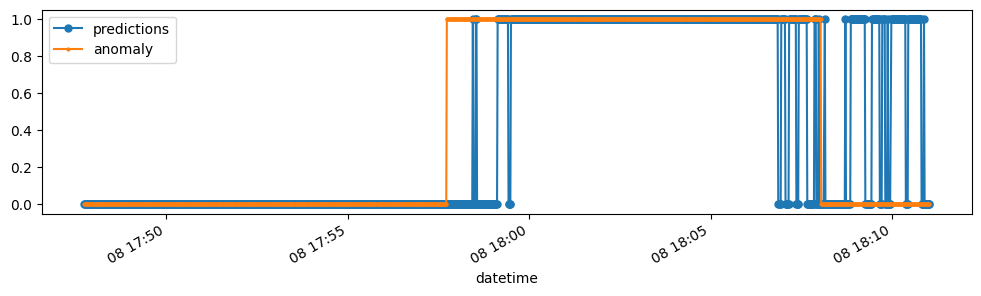

In [108]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

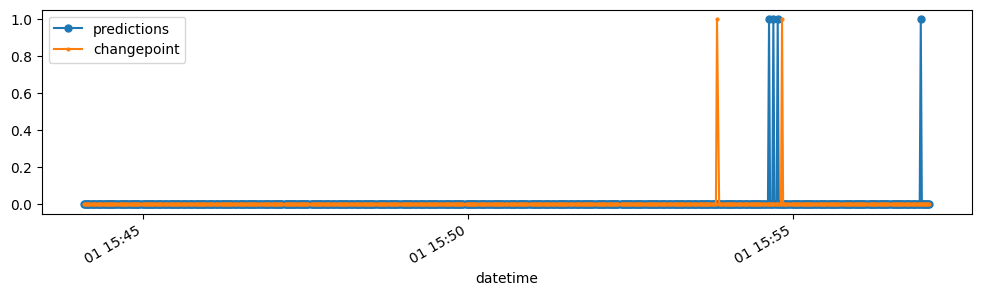

In [109]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

##### Оценка точности для задачи поиска аномалий

In [110]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [111]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.5999726685172256
Precision:  0.8222032759366772
Recall:  0.5400537218486181


Для одного временного ряда

<Axes: >

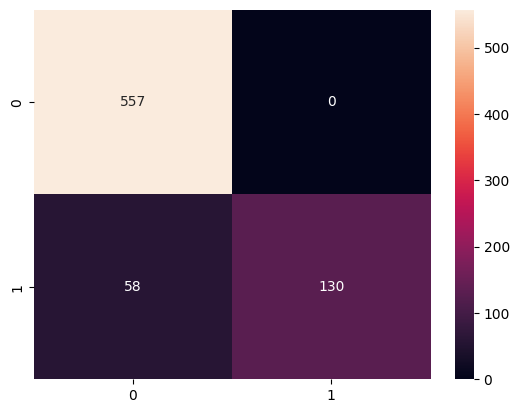

In [112]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

In [113]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       557
         1.0       1.00      0.69      0.82       188

    accuracy                           0.92       745
   macro avg       0.95      0.85      0.88       745
weighted avg       0.93      0.92      0.92       745



##### Оценка точности для задачи поиска точек изменения состояния

In [114]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [115]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.02107843137254902
Precision:  0.016968325791855202
Recall:  0.03676470588235294


In [116]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.1.6 Случайный лес


+ n_estimators - количество алгоритмов

+ max_depth - максимальная глубина
+ min_samples_split: определяет минимальное количество выборок, которое должен содержать внутренний узел для разделения на дополнительные узлы. Обычно мы сохраняем значение min_samples_split в диапазоне от 2 до 6. 
+ min_samples_leaf - Определяет минимальное количество выборок, которое узел должен хранить после разделения. Это также помогает уменьшить переобучение, когда у нас достаточно параметров. 
+ max_features: Случайный лес берет случайные подмножества объектов и пытается найти наилучшее разделение. max_features помогает определить количество объектов, которые необходимо учитывать, чтобы произвести наилучшее разделение. Он может принимать четыре значения “auto“, “sqrt“, “log2” и "None".
+ max_leaf_nodes: Он устанавливает ограничение на разбиение узла и, таким образом, помогает уменьшить глубину дерева и эффективно помогает уменьшить переобучение. Если значение равно None, дерево продолжает расти бесконечно.
+ max_samples: Этот гиперпараметр помогает выбрать максимальное количество выборок из обучающего набора данных для обучения каждого отдельного дерева.


https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/?ysclid=lwz39v0p8w423572858

In [117]:
%%time
look_back = 5
Q = 0.98

# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    test = df.drop(['anomaly','changepoint'], axis=1)
    y = df["anomaly"]
    
    
    # Берем признак - Расход
    X_train, y_train = create_dataset(train['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    
    X_test, y_test = create_dataset(test['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    
    
    # инициализация модели
    model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=10, min_samples_split=6, 
                             max_leaf_nodes=10, max_features="auto", max_samples=10)
    # обучение модели
    model.fit(X_train, y_train)
    
    # построение прогноза, расчет невязки и подбор порога на обучающей выборке
    residuals_train = pd.DataFrame(y_train - model.predict(X_train)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) 
    
    #предсказание на тестовой выборке
    residuals = pd.DataFrame(y_test - model.predict(X_test)).abs().sum(axis=1)
    
    anomalous_data = residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(look_back - 1, len(X_test) - look_back + 1):
        if np.all(anomalous_data[data_idx - look_back + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=test.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    
    # поиск точек изменения состояния в прогнозе аномалий и сохранение в массив
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 9.65 s, sys: 44.7 ms, total: 9.69 s
Wall time: 9.7 s


##### Визуализация результатов моделирования

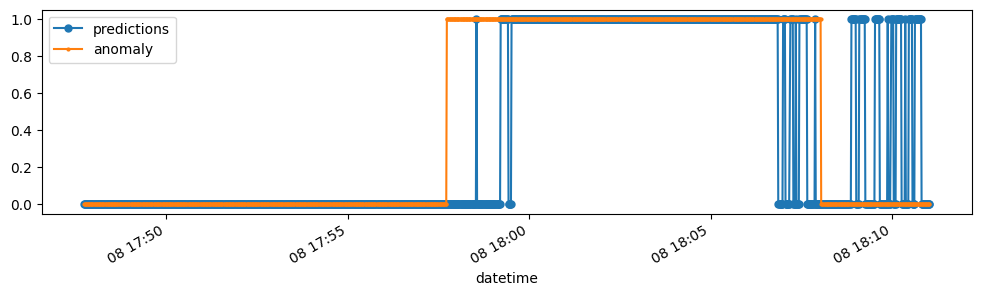

In [118]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

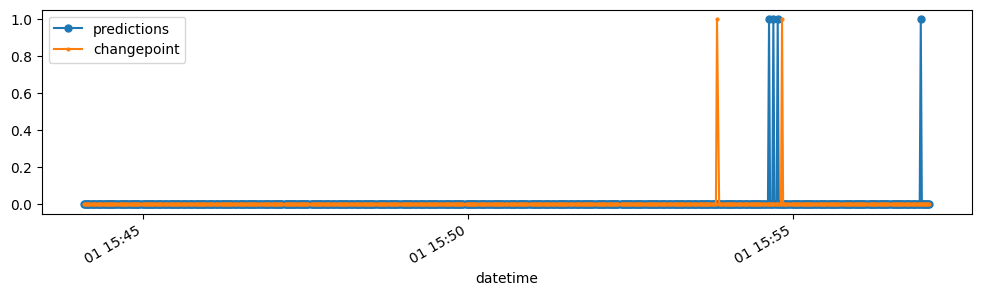

In [119]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

##### Оценка точности для задачи поиска аномалий

In [120]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [121]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.5986412335938975
Precision:  0.8382393808583253
Recall:  0.5366869968771878


Для одного временного ряда

<Axes: >

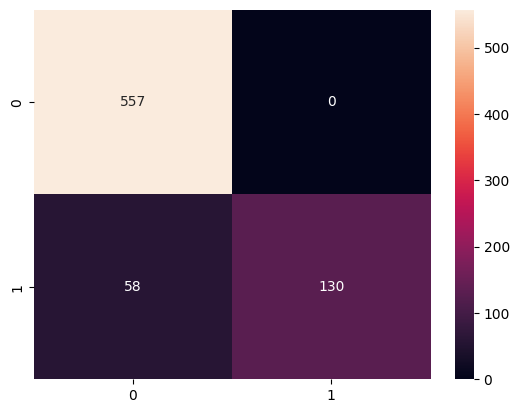

In [122]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

In [123]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       557
         1.0       1.00      0.69      0.82       188

    accuracy                           0.92       745
   macro avg       0.95      0.85      0.88       745
weighted avg       0.93      0.92      0.92       745



##### Оценка точности для задачи поиска точек изменения состояния

In [124]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [125]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.010813148788927337
Precision:  0.009313725490196078
Recall:  0.022058823529411766


In [126]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.1.7 Бустинг

Наиболее важные гиперпараметры модели:

    скорость обучения (learning_rate);

    количество деревьев (n_estimators);

    процент подвыборки (subsample);

    глубина дерева (max_depth).
    
Скорость обучения контролирует вклад каждого дерева в ансамбль. Разумные значения меньше 1,0 и немного больше 0,0 (например, 1e-8).

Количество деревьев контролирует размер ансамбля, и часто, чем больше деревьев, тем лучше до точки уменьшения отдачи. Разумные значения лежат между 1 деревом и сотнями или тысячами деревьев.

Проценты подвыборки определяют размер случайной выборки, используемый для обучения каждого дерева, определяемый как процент от размера исходного набора данных. Значения находятся в диапазоне от немного выше 0,0 (например, 1e-8) до 1,0.

Глубина дерева — это количество уровней в каждом дереве. Более глубокие деревья более специфичны для обучающего набора данных и, возможно, переоснащены. Деревья, меньшие по размеру, часто лучше обобщают. Разумные значения находятся в диапазоне от 1 до 10 или 20.

|**Название**|**Описание**|**Тип**|**Значение по умолчанию**|**Границы**|
| :- | :- | :- | :- | :- |
|max\_depth                |максимальная глубина дерева|int or None  |3|[1, inf)        |
|max\_features             |количество признаков, учитываемых алгоритмом, при построении расщепления в дереве|int или float |`  `None       |[1, n\_features) |
|subsample                |доля наблюдений из выборки, используемых для построения одного дерева|float        |1|(0.0, 1.0]      |
|min\_samples\_split        |минимальное число объектов, при котором происходит расщепление|float or int |2|(0.0, 1.0]      |
|min\_samples\_leaf         |минимальное число объектов в листе (узле)|float or int |1|(0.0, 1.0)      |
|<p>min\_weight\_</p><p>fraction\_leaf </p>|минимальная доля объектов в листе (узле) с учетом весов объектов|float        |0|[0.0, 0.5]      |
|<p>min\_impurity\_</p><p>decrease    </p>|узел будет разделен, если такое разделение вызовет уменьшение примеси на величину, большую данного числа|float        |0|[0.0, inf)      |
|max\_leaf\_nodes           |Максимальное число узлов в дереве|int          |`  `None       |[2, inf)        |
|learning\_rate            |скорость обучения|float        |0\.1|[0.0, inf)      |
|n\_estimators             |количество деревьев|int          |100|[1, inf)        |



In [127]:
%%time
look_back = 5
Q = 0.98

# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    test = df.drop(['anomaly','changepoint'], axis=1)
    y = df["anomaly"]
    
    
    # Берем признак - Расход
    X_train, y_train = create_dataset(train['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    
    X_test, y_test = create_dataset(test['Volume Flow RateRMS'].values.reshape(-1,1), look_back)
    
    
    model = XGBRegressor(learning_rate = 0.001, n_estimators = 100, max_depth = 15, subsample = 1)
    # обучение модели
    model.fit(X_train, y_train)
    
    # построение прогноза, расчет невязки и подбор порога на обучающей выборке
    residuals_train = pd.DataFrame(y_train - model.predict(X_train)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) 
    
    #предсказание на тестовой выборке
    residuals = pd.DataFrame(y_test - model.predict(X_test)).abs().sum(axis=1)
    
    anomalous_data = residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(look_back - 1, len(X_test) - look_back + 1):
        if np.all(anomalous_data[data_idx - look_back + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=test.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    
    # поиск точек изменения состояния в прогнозе аномалий и сохранение в массив
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 21 s, sys: 429 ms, total: 21.4 s
Wall time: 7.07 s


##### Визуализация результатов моделирования

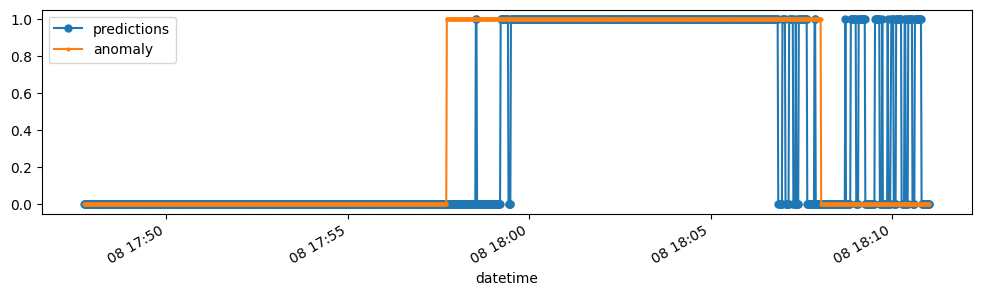

In [128]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

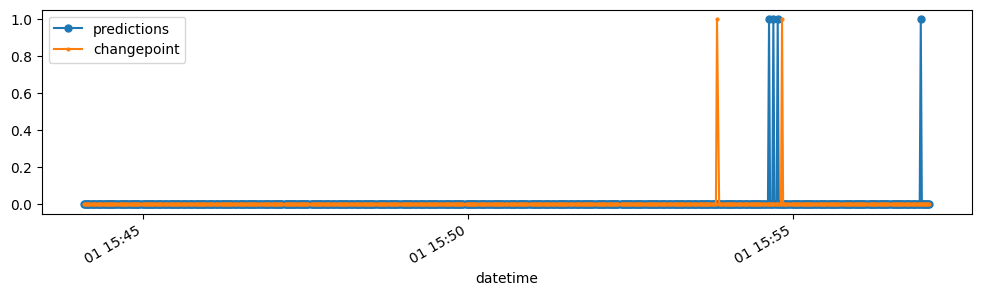

In [129]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

##### Оценка точности для задачи поиска аномалий

In [130]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [131]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.5999569555074078
Precision:  0.8365240818956245
Recall:  0.5391317368344984


Для одного временного ряда

<Axes: >

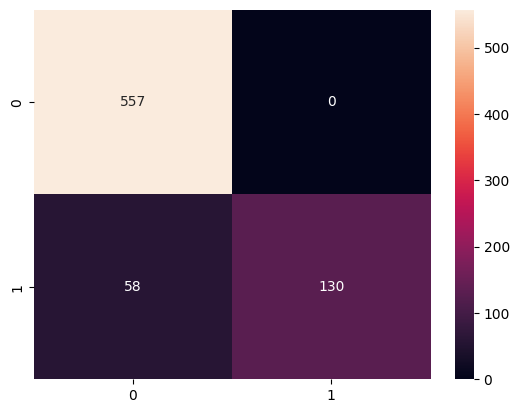

In [132]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

In [133]:
print(classification_report(true_outlier[0], 
    predicted_outlier[0]))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       557
         1.0       1.00      0.69      0.82       188

    accuracy                           0.92       745
   macro avg       0.95      0.85      0.88       745
weighted avg       0.93      0.92      0.92       745



##### Оценка точности для задачи поиска точек изменения состояния

In [134]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [135]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.010813148788927337
Precision:  0.009313725490196078
Recall:  0.022058823529411766


In [136]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


### 4.2.3 Многомерное (3D) прогнозирование

In [137]:
# параметры для моделирования и подбора порога
N_STEPS = 3
Q = 0.99

In [138]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

Проверка размерности массивов

In [139]:

X_train = df[:400].drop(['anomaly','changepoint'], axis=1)

# scaler init and fitting
StSc = StandardScaler()
StSc.fit(X_train)

# convert into input/output
X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    

In [140]:
X.shape

(397, 3, 11)

397 строк (дата и время), 3 временных шага, 11 признаков

In [141]:
X[:,:,1].shape # взять один признак (3-е измерение)

(397, 3)

In [142]:
y.shape

(397, 11)

11 признаков, фактическое значение на точку вперед для каждой временной метки

#### 4.2.2.1 Линейная регрессия (с регуляризацией)

In [143]:
Q = 0.90

In [144]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    residuals_train = pd.DataFrame()
    residuals_test_sum = pd.DataFrame()
    residuals =  pd.DataFrame()
    
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    
    
    # model fitting
    for i in range(X.shape[2]):
        model = Ridge()
        model.fit(X[:,:,i], y[:,i])
        residuals_train[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
    
    # results predicting
    residuals_train_sum = residuals_train.abs().sum(axis=1)
    UCL = residuals_train_sum.quantile(Q) * 1.1
    
    # results predicting
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    
    for i in range(X.shape[2]):
        residuals[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
        
    residuals_test_sum = residuals.abs().sum(axis=1)
    
    anomalous_data = residuals_test_sum > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 4 s, sys: 1.8 ms, total: 4 s
Wall time: 4.02 s


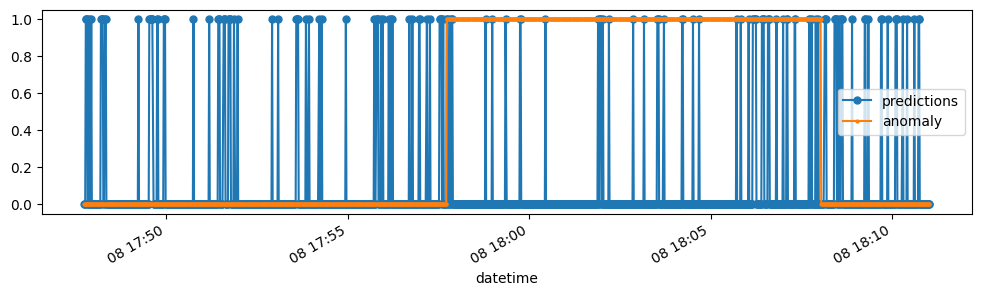

In [145]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

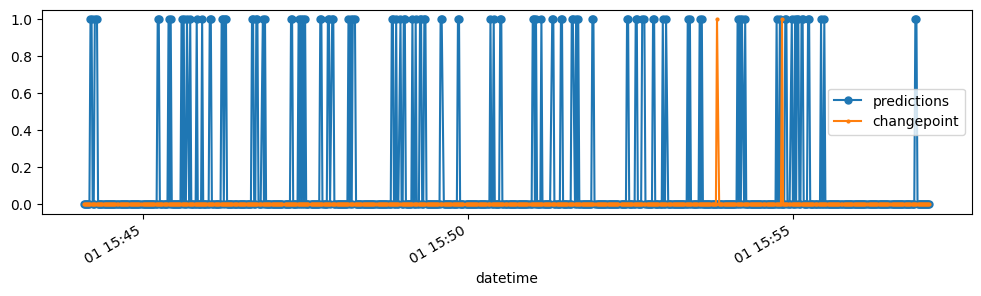

In [146]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

In [147]:
true_outlier[0]

datetime
2020-03-01 15:44:06    0.0
2020-03-01 15:44:07    0.0
2020-03-01 15:44:08    0.0
2020-03-01 15:44:09    0.0
2020-03-01 15:44:10    0.0
                      ... 
2020-03-01 15:57:02    1.0
2020-03-01 15:57:03    1.0
2020-03-01 15:57:04    1.0
2020-03-01 15:57:05    1.0
2020-03-01 15:57:06    1.0
Name: anomaly, Length: 745, dtype: float64

In [148]:
predicted_outlier[0]

datetime
2020-03-01 15:44:06    0
2020-03-01 15:44:07    0
2020-03-01 15:44:08    0
2020-03-01 15:44:09    0
2020-03-01 15:44:10    0
                      ..
2020-03-01 15:57:02    0
2020-03-01 15:57:03    0
2020-03-01 15:57:04    0
2020-03-01 15:57:05    0
2020-03-01 15:57:06    0
Length: 745, dtype: int64

In [149]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [150]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.3932726977886481
Precision:  0.5812279014455135
Recall:  0.334841612574194


<Axes: >

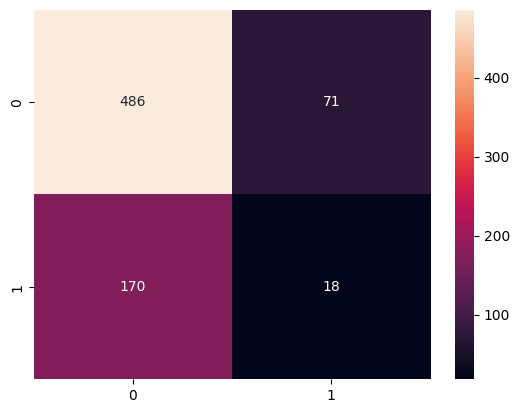

In [151]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

##### Оценка точности для задачи поиска точек изменения состояния

In [152]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [153]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.00894854097792537
Precision:  0.004622659742431119
Recall:  0.17401960784313725


In [154]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.2.2 Дерево решений

In [155]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    residuals_train = pd.DataFrame()
    residuals_test_sum = pd.DataFrame()
    residuals =  pd.DataFrame()
    
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    
    
    # model fitting
    for i in range(X.shape[2]):
        model = DecisionTreeRegressor(max_depth=10)
        model.fit(X[:,:,i], y[:,i])
        residuals_train[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
    
    # results predicting
    residuals_train_sum = residuals_train.abs().sum(axis=1)
    UCL = residuals_train_sum.quantile(Q) * 2
    
    # results predicting
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    
    for i in range(X.shape[2]):
        residuals[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
        
    residuals_test_sum = residuals.abs().sum(axis=1)
    
    anomalous_data = residuals_test_sum > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 4.22 s, sys: 1.33 ms, total: 4.22 s
Wall time: 4.23 s


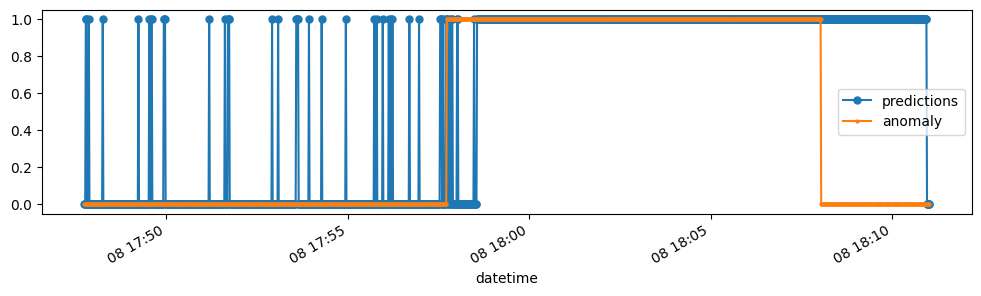

In [156]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

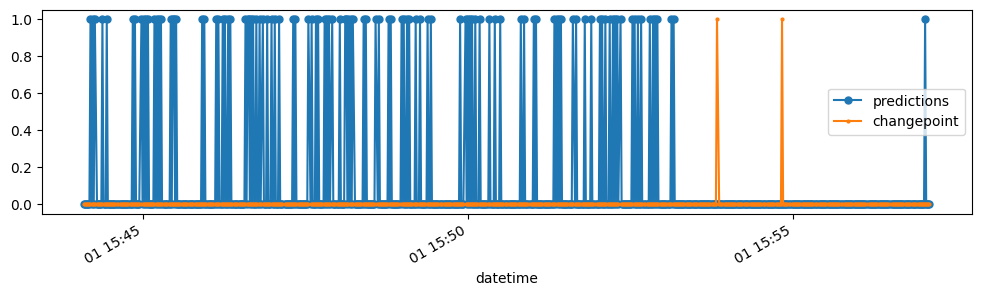

In [157]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

In [161]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [162]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.6162217138427514
Precision:  0.48905773034620026
Recall:  0.9020620757758805


<Axes: >

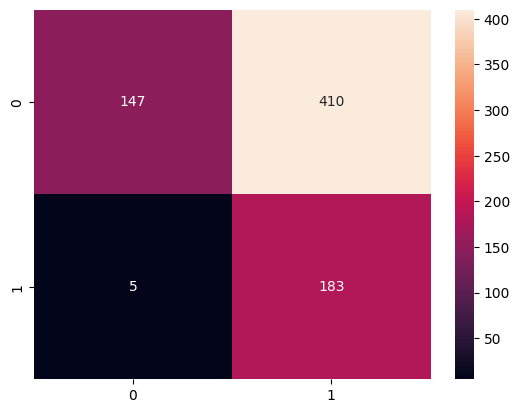

In [163]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

##### Оценка точности для задачи поиска точек изменения состояния

In [164]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [165]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.004439914991547382
Precision:  0.0022921791062506685
Recall:  0.07598039215686274


In [166]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.2.3 SVR

In [167]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    residuals_train = pd.DataFrame()
    residuals_test_sum = pd.DataFrame()
    residuals =  pd.DataFrame()
    
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    
    
    # model fitting
    for i in range(X.shape[2]):
        model = SVR(kernel = "rbf", C = 1, max_iter = -1)
        model.fit(X[:,:,i], y[:,i])
        residuals_train[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
    
    # results predicting
    residuals_train_sum = residuals_train.abs().sum(axis=1)
    UCL = residuals_train_sum.quantile(Q) * 1.2
    
    # results predicting
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    
    for i in range(X.shape[2]):
        residuals[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
        
    residuals_test_sum = residuals.abs().sum(axis=1)
    
    anomalous_data = residuals_test_sum > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 13.4 s, sys: 0 ns, total: 13.4 s
Wall time: 13.4 s


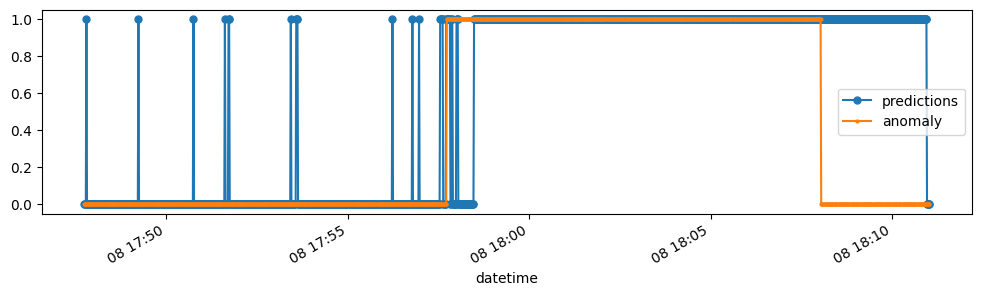

In [168]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

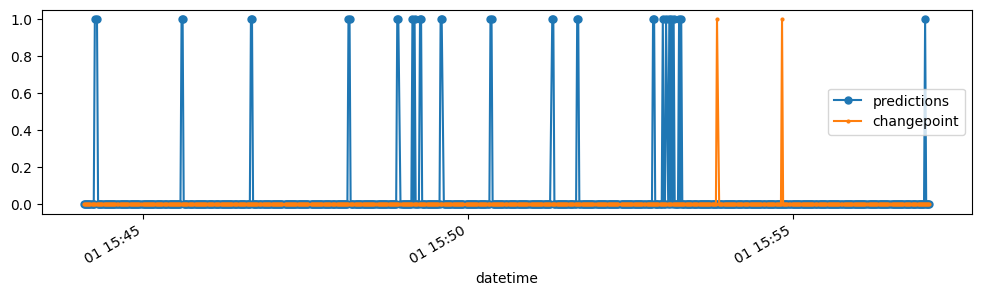

In [169]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

In [170]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [171]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.76253023896625
Precision:  0.6913872393725972
Recall:  0.8796334170662637


<Axes: >

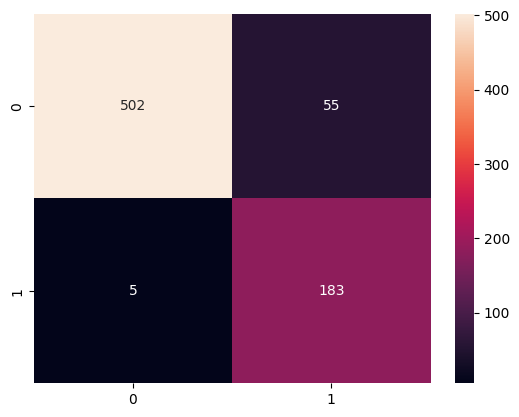

In [172]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

##### Оценка точности для задачи поиска точек изменения состояния

In [173]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [174]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.006486099684629097
Precision:  0.0035192491714710504
Recall:  0.051470588235294115


In [175]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.3.4 Случайный лес

In [176]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    residuals_train = pd.DataFrame()
    residuals_test_sum = pd.DataFrame()
    residuals =  pd.DataFrame()
    
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    
    
    # model fitting
    for i in range(X.shape[2]):
        # инициализация модели
        model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=10, min_samples_split=6, 
                             max_leaf_nodes=10, max_features="auto", max_samples=10)
        model.fit(X[:,:,i], y[:,i])
        residuals_train[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
    
    # results predicting
    residuals_train_sum = residuals_train.abs().sum(axis=1)
    UCL = residuals_train_sum.quantile(Q) 
    
    # results predicting
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    
    for i in range(X.shape[2]):
        residuals[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
        
    residuals_test_sum = residuals.abs().sum(axis=1)
    
    anomalous_data = residuals_test_sum > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 1min 29s, sys: 687 ms, total: 1min 30s
Wall time: 1min 30s


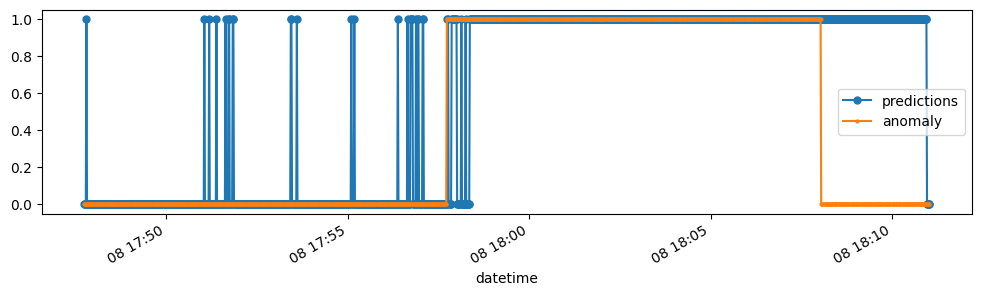

In [177]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

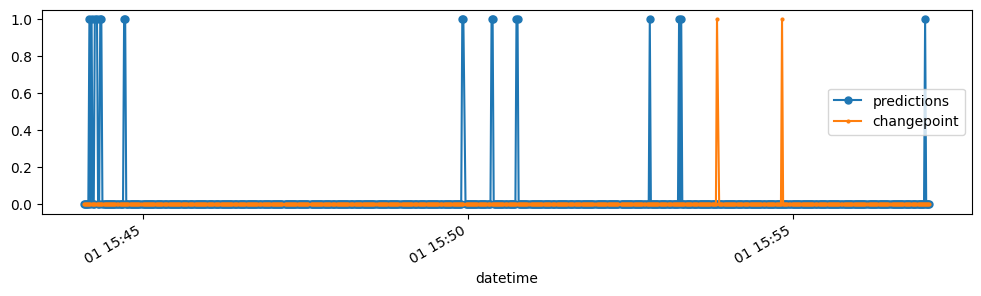

In [178]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

In [179]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [180]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.752350351874306
Precision:  0.678424975789391
Recall:  0.8887099862966917


<Axes: >

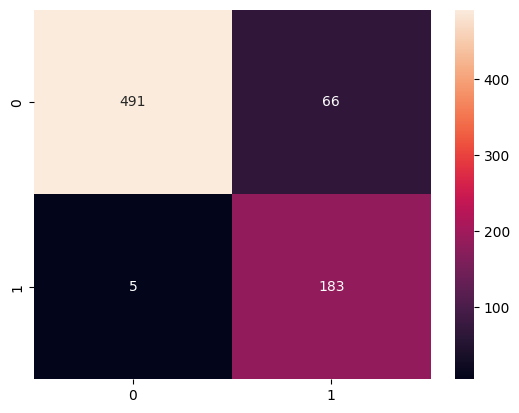

In [181]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

##### Оценка точности для задачи поиска точек изменения состояния

In [182]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [183]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.007971845565894814
Precision:  0.00431144487270382
Recall:  0.06127450980392156


In [184]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


#### 4.2.3.5 Бустинг

In [185]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    residuals_train = pd.DataFrame()
    residuals_test_sum = pd.DataFrame()
    residuals =  pd.DataFrame()
    
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    
    
    # model fitting
    for i in range(X.shape[2]):
        model = XGBRegressor(learning_rate = 0.0001, n_estimators = 100, max_depth = 15, subsample = 1)
        model.fit(X[:,:,i], y[:,i])
        residuals_train[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
    
    # results predicting
    residuals_train_sum = residuals_train.abs().sum(axis=1)
    UCL = residuals_train_sum.quantile(Q)
    
    # results predicting
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    
    for i in range(X.shape[2]):
        residuals[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
        
    residuals_test_sum = residuals.abs().sum(axis=1)
    
    anomalous_data = residuals_test_sum > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 5min 11s, sys: 6.2 s, total: 5min 17s
Wall time: 1min 23s


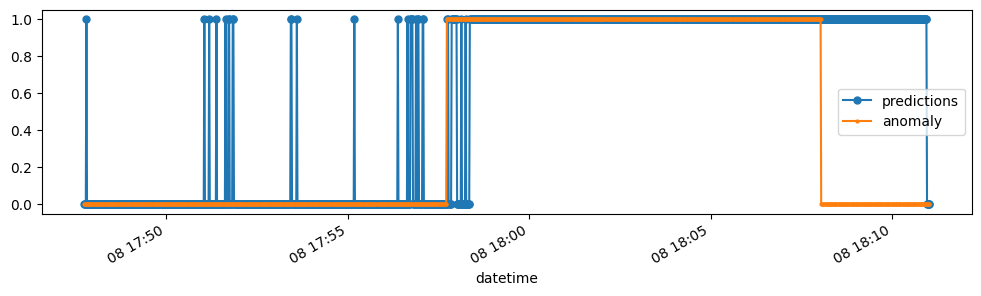

In [186]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

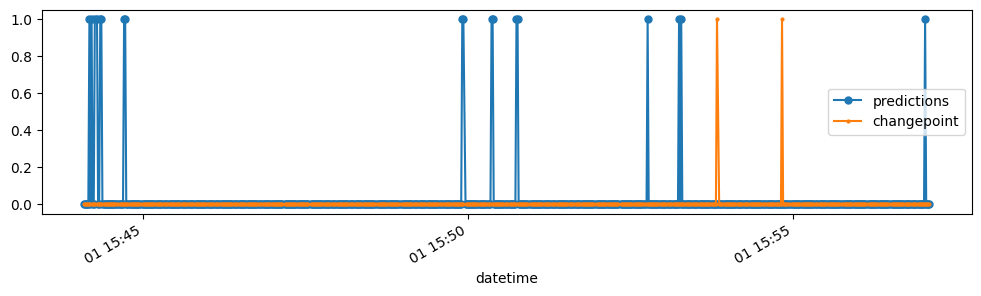

In [187]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

In [188]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [189]:
print("F1: ", np.array(f1).mean())

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.7510929738095168
Precision:  0.6751438686712977
Recall:  0.8889465335282762


<Axes: >

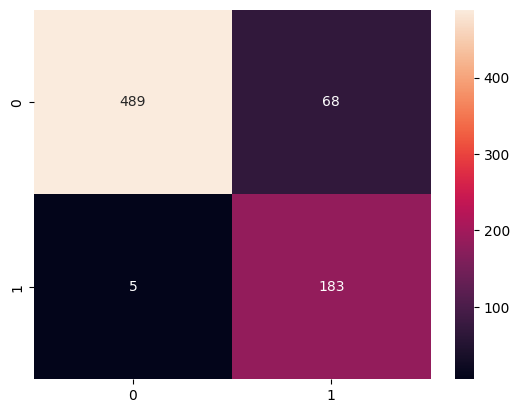

In [190]:
sns.heatmap(confusion_matrix(true_outlier[0], predicted_outlier[0]), annot = True, fmt = ".0f")

##### Оценка точности для задачи поиска точек изменения состояния

In [191]:
f1_cp = []
precision_cp = []
recall_cp = []
for i in range(len(true_outlier)):
    f1_cp.append(f1_score(true_cp[i], predicted_cp[i]))
    precision_cp.append(precision_score(true_cp[i], predicted_cp[i]))    
    recall_cp.append(recall_score(true_cp[i], predicted_cp[i]))        

In [192]:
print("F1: ", np.array(f1_cp).mean())

print("Precision: ", np.array(precision_cp).mean())

print("Recall: ", np.array(recall_cp).mean())

F1:  0.0077121791801116075
Precision:  0.004166058554404789
Recall:  0.06127450980392156


In [193]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-01 15:56:20'), Timestamp('2020-03-01 15:52:20'))
Intersection of scoring windows(Timestamp('2020-02-08 18:00:14'), Timestamp('2020-02-08 17:56:08'))
Intersection of scoring windows(Timestamp('2020-02-08 18:06:52'), Timestamp('2020-02-08 18:05:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:23:12'), Timestamp('2020-02-08 18:18:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:29:26'), Timestamp('2020-02-08 18:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:47:21'), Timestamp('2020-02-08 18:44:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:54:07'), Timestamp('2020-02-08 18:49:25'))
Intersection of scoring windows(Timestamp('2020-02-08 18:59:59'), Timestamp('2020-02-08 18:56:00'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:00'), Timestamp('2020-02-08 18:59:59'))
Intersection of scoring windows(Timestamp('2020-02-08 19:04:59'), Timestamp('2020-02-08 19:01:06'))


# 5. Сохранение предсказания модели

## 5.1 Обучение модели и формирование предсказания

Загрузка тестовой выборки

In [194]:
# чтение имен всех файлов с данными

all_files = []
for root, dirs, files in os.walk("/kaggle/input/ml-cource-cifrum-anomaly-public/data"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(f'{root}/{file}')

print("Список файлов:")
all_files.sort()

Список файлов:


In [195]:
# загрузка данных
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

In [196]:
len(list_of_df)

34

In [197]:
pd.concat(list_of_df)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.277940,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0
2020-03-01 15:44:07,0.082724,0.132378,1.121180,-0.273216,92.0144,22.2577,221.250,76.9806,0.0,0.0
2020-03-01 15:44:08,0.081648,0.139038,1.932420,0.054711,92.2413,22.2748,236.615,76.0197,0.0,0.0
2020-03-01 15:44:09,0.083335,0.132742,1.259620,-0.273216,92.2438,22.2657,230.375,77.0000,0.0,0.0
2020-03-01 15:44:10,0.082272,0.133171,1.597730,0.054711,92.3611,22.2591,249.701,77.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-09 17:14:04,0.026853,0.038926,0.740614,0.054711,69.6371,24.1045,237.276,32.0451,0.0,0.0
2020-03-09 17:14:05,0.027067,0.038430,0.988875,0.054711,69.6731,24.1046,230.729,32.9562,0.0,0.0
2020-03-09 17:14:07,0.027582,0.038836,0.588439,0.054711,69.6959,24.1020,233.443,32.0000,0.0,0.0


In [198]:
for n in range(len(list_of_df)):
    df = list_of_df[n]
    for col in df.columns:
        df[df < 0] = 0
    list_of_df[n] = df   

ver 1

In [199]:
for ind in range(len(list_of_df)):
    # разница температур (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Temperature_diff"] = list_of_df[ind]['Temperature'] - list_of_df[ind]['Thermocouple'] 
    # разница акселлерометров (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Accel_diff"] = list_of_df[ind]['Accelerometer1RMS'] / list_of_df[ind]['Accelerometer2RMS'] 
    # сглаживания
    list_of_df[ind]["Volume Flow RateRMS_10mean"] = list_of_df[ind]["Volume Flow RateRMS"].rolling(window = 10, min_periods=0).mean()

ver 2

In [ ]:
for ind in rangelen(list_of_df)):
    # разница температур (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Temperature_diff"] = list_of_df[ind]['Temperature'] - list_of_df[ind]['Thermocouple'] 
    # разница акселлерометров (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Accel_diff"] = list_of_df[ind]['Accelerometer1RMS'] / list_of_df[ind]['Accelerometer2RMS'] 
    # сглаживания
    list_of_df[ind]["Volume Flow RateRMS_10mean"] = list_of_df[ind]["Volume Flow RateRMS"].rolling(window = 10, min_periods=0).mean()

In [200]:
# параметры для моделирования и подбора порога
N_STEPS = 3
Q = 0.99

In [201]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [202]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    residuals_train = pd.DataFrame()
    residuals_test_sum = pd.DataFrame()
    residuals =  pd.DataFrame()
    
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    
    
    # model fitting
    for i in range(X.shape[2]):
        # инициализация модели
        model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=10, min_samples_split=6, 
                             max_leaf_nodes=10, max_features="auto", max_samples=10)
        model.fit(X[:,:,i], y[:,i])
        residuals_train[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
        
    # results predicting
    residuals_train_sum = residuals_train.abs().sum(axis=1)
    UCL = residuals_train_sum.quantile(Q) 
    
    # results predicting
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    
    for i in range(X.shape[2]):
        residuals[f"feature{i}"] = pd.DataFrame(y[:,i] - model.predict(X[:,:,i])).abs().sum(axis=1)
        
    residuals_test_sum = residuals.abs().sum(axis=1)
    
    anomalous_data = residuals_test_sum > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    
    #prediction = pd.Series((residuals_test_sum > UCL).astype(int).values, 
     #                           index=df[N_STEPS:].index).fillna(0)
    
    
    
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: user 1min 28s, sys: 674 ms, total: 1min 28s
Wall time: 1min 29s


#### Оценка точности для задачи поиска аномалий

In [203]:
f1 = []
precision = []
recall = []
for i in range(len(true_outlier)):
    f1.append(f1_score(true_outlier[i], predicted_outlier[i]))
    precision.append(precision_score(true_outlier[i], predicted_outlier[i]))    
    recall.append(recall_score(true_outlier[i], predicted_outlier[i]))        

In [204]:
print("F1: ", np.mean(np.array(f1)))

print("Precision: ", np.array(precision).mean())

print("Recall: ", np.array(recall).mean())

F1:  0.7686729379378954
Precision:  0.7608720991795979
Recall:  0.8248817307923166


## Сохраняем предсказание

In [206]:
# формирование вектора предсказаний по всем экспериментам
pred = pd.concat(predicted_outlier)

In [207]:
pred

datetime
2020-03-01 15:44:06    0
2020-03-01 15:44:07    0
2020-03-01 15:44:08    0
2020-03-01 15:44:09    0
2020-03-01 15:44:10    0
                      ..
2020-03-09 17:14:04    0
2020-03-09 17:14:05    0
2020-03-09 17:14:07    0
2020-03-09 17:14:08    0
2020-03-09 17:14:09    0
Length: 37401, dtype: int64

In [208]:
y_pred=pd.Series(pred, name = "anomaly")

In [209]:
y_pred.index = np.arange(0, y_pred.shape[0])

In [210]:
y_pred

0        0
1        0
2        0
3        0
4        0
        ..
37396    0
37397    0
37398    0
37399    0
37400    0
Name: anomaly, Length: 37401, dtype: int64

In [211]:
y_pred = y_pred.reset_index()
y_pred.columns = ["id", "anomaly"]

In [212]:
y_pred

,id,anomaly
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
37396,37396,0
37397,37397,0
37398,37398,0
37399,37399,0


In [213]:
y_pred["anomaly"].value_counts()

anomaly
0    23161
1    14240
Name: count, dtype: int64

In [214]:
y_pred.to_csv("predict.csv", index = False)